<a href="https://colab.research.google.com/github/woojin9605/Practice/blob/main/FCN_32_16_8s.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%shell
wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip .
unzip PennFudanPed.zip

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import models
from torchvision.models.vgg import VGG
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
from torch.autograd import Variable

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def get_upsampling_weight(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:kernel_size, :kernel_size]
    filt = (1 - abs(og[0] - center) / factor) * (1 - abs(og[1] - center) / factor)
    weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size), dtype=np.float64)
    weight[list(range(in_channels)), list(range(out_channels)), :, :] = filt
    return torch.from_numpy(weight).float()

class FCN32s(nn.Module):
  def __init__(self, num_classes, pretrained=True):
    super().__init__()
    vgg16 = models.vgg16(pretrained=True)
    features, classifier = list(vgg16.features.children()), list(vgg16.classifier.children())
    features[0].padding = (100, 100)
    for f in features:
      if 'MaxPool' in f.__class__.__name__:
        f.ceil_mode = True
      elif 'ReLU' in f.__class__.__name__:
        f.inplace = True

    self.features5 = nn.Sequential(*features)

    fc6 = nn.Conv2d(512, 4096, kernel_size=7)
    fc6.weight.data.copy_(classifier[0].weight.data.view(4096, 512, 7, 7))
    fc6.bias.data.copy_(classifier[0].bias.data)

    fc7 = nn.Conv2d(4096, 4096, kernel_size=1)
    fc7.weight.data.copy_(classifier[3].weight.data.view(4096, 4096, 1, 1))
    fc7.bias.data.copy_(classifier[3].bias.data)

    score_fr = nn.Conv2d(4096, num_classes, kernel_size=1)
    score_fr.weight.data.zero_()
    score_fr.bias.data.zero_()

    self.score_fr = nn.Sequential(fc6, nn.ReLU(inplace=True), nn.Dropout(), 
                                  fc7, nn.ReLU(inplace=True), nn.Dropout(), score_fr)
    self.upscore = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=64, stride=32, bias=False)
    self.upscore.weight.data.copy_(get_upsampling_weight(num_classes, num_classes, 64)) 

  def forward(self, x):
    x_size = x.size()
    pool5 = self.features5(x)
    score_fr = self.score_fr(pool5)
    upscore = self.upscore(score_fr)
    return upscore[:, :, 19: (19 + x_size[2]), 19: (19 + x_size[3])].contiguous()

class FCN16s(nn.Module):
  def __init__(self, num_classes, pretrained=True):
    super().__init__()
    vgg16 = models.vgg16(pretrained=True)
    features, classifier = list(vgg16.features.children()), list(vgg16.classifier.children())
    features[0].padding = (100, 100)
    for f in features:
      if 'MaxPool' in f.__class__.__name__:
        f.ceil_mode = True
      elif 'ReLU' in f.__class__.__name__:
        f.inplace = True

    self.features4 = nn.Sequential(*features[: 24])
    self.features5 = nn.Sequential(*features[24: ])

    self.score_pool4 = nn.Conv2d(512, num_classes, kernel_size=1)


    fc6 = nn.Conv2d(512, 4096, kernel_size=7)
    fc6.weight.data.copy_(classifier[0].weight.data.view(4096, 512, 7, 7))
    fc6.bias.data.copy_(classifier[0].bias.data)

    fc7 = nn.Conv2d(4096, 4096, kernel_size=1)
    fc7.weight.data.copy_(classifier[3].weight.data.view(4096, 4096, 1, 1))
    fc7.bias.data.copy_(classifier[3].bias.data)

    score_fr = nn.Conv2d(4096, num_classes, kernel_size=1)
    score_fr.weight.data.zero_()
    score_fr.bias.data.zero_()

    self.score_fr = nn.Sequential(fc6, nn.ReLU(inplace=True), nn.Dropout(), 
                                  fc7, nn.ReLU(inplace=True), nn.Dropout(), score_fr)
    
    self.upscore_2 =  nn.ConvTranspose2d(num_classes, num_classes, kernel_size=4, stride=2, bias=False)
    self.upscore_16 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=32, stride=16, bias=False)
    self.upscore_2.weight.data.copy_(get_upsampling_weight(num_classes, num_classes, 4))
    self.upscore_16.weight.data.copy_(get_upsampling_weight(num_classes, num_classes, 32))
  
  def forward(self, x):
    x_size = x.size()
    pool4 = self.features4(x)
    pool5 = self.features5(pool4)

    score_fr = self.score_fr(pool5)
    upscore_2 = self.upscore_2(score_fr)

    score_pool4 = self.score_pool4(pool4)
    #print(upscore_2.shape,score_pool4[:, :, 5: (5 + upscore_2.size()[2]), 5: (5 + upscore_2.size()[3])].shape)
    
    score_sum = upscore_2 + score_pool4[:, :, 5: (5 + upscore_2.size()[2]), 5: (5 + upscore_2.size()[3])]

    upscore_16 = self.upscore_16(score_sum)

    return upscore_16[:, :, 27: (27 + x_size[2]), 27: (27 + x_size[3])].contiguous()

class FCN8s(nn.Module):
  def __init__(self, num_classes, pretrained=True):
    super().__init__()
    vgg16 = models.vgg16(pretrained=True)
    features, classifier = list(vgg16.features.children()), list(vgg16.classifier.children())
    features[0].padding = (100, 100)
    for f in features:
      if 'MaxPool' in f.__class__.__name__:
        f.ceil_mode = True
      elif 'ReLU' in f.__class__.__name__:
        f.inplace = True

    self.features3 = nn.Sequential(*features[: 17])
    self.features4 = nn.Sequential(*features[17: 24])
    self.features5 = nn.Sequential(*features[24: ])

    self.score_pool3 = nn.Conv2d(256, num_classes, kernel_size=1)
    self.score_pool4 = nn.Conv2d(512, num_classes, kernel_size=1)

    fc6 = nn.Conv2d(512, 4096, kernel_size=7)
    fc6.weight.data.copy_(classifier[0].weight.data.view(4096, 512, 7, 7))
    fc6.bias.data.copy_(classifier[0].bias.data)

    fc7 = nn.Conv2d(4096, 4096, kernel_size=1)
    fc7.weight.data.copy_(classifier[3].weight.data.view(4096, 4096, 1, 1))
    fc7.bias.data.copy_(classifier[3].bias.data)

    score_fr = nn.Conv2d(4096, num_classes, kernel_size=1)
    score_fr.weight.data.zero_()
    score_fr.bias.data.zero_()

    self.score_fr = nn.Sequential(fc6, nn.ReLU(inplace=True), nn.Dropout(), 
                                  fc7, nn.ReLU(inplace=True), nn.Dropout(), score_fr)
    
    self.upscore_2_1 =  nn.ConvTranspose2d(num_classes, num_classes, kernel_size=4, stride=2, bias=False)
    self.upscore_2_2 =  nn.ConvTranspose2d(num_classes, num_classes, kernel_size=4, stride=2, bias=False)
    self.upscore_8 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=16, stride=8, bias=False)

    self.upscore_2_1.weight.data.copy_(get_upsampling_weight(num_classes, num_classes, 4))
    self.upscore_2_2.weight.data.copy_(get_upsampling_weight(num_classes, num_classes, 4))
    self.upscore_8.weight.data.copy_(get_upsampling_weight(num_classes, num_classes, 16))
  
  def forward(self, x):
    x_size = x.size()
    pool3 = self.features3(x)
    pool4 = self.features4(pool3)
    pool5 = self.features5(pool4)

    score_fr = self.score_fr(pool5)
    upscore_2_1 = self.upscore_2_1(score_fr)
    score_pool4 = self.score_pool4(pool4)
    #print(upscore_2.shape,score_pool4[:, :, 5: (5 + upscore_2.size()[2]), 5: (5 + upscore_2.size()[3])].shape)
    score_sum_1 = upscore_2_1 + score_pool4[:, :, 5: (5 + upscore_2_1.size()[2]), 5: (5 + upscore_2_1.size()[3])]

    upscore_2_2 = self.upscore_2_2(score_sum_1)
    score_pool3 = self.score_pool3(pool3)

    #print(upscore_2_2.shape,score_pool3[:, :, 5: (5 + upscore_2_2.size()[2]), 5: (5 + upscore_2_2.size()[3])].shape)

    score_sum_2 = upscore_2_2 + score_pool3[:, :, 9: (9 + upscore_2_2.size()[2]), 9: (9 + upscore_2_2.size()[3])]
    upscore_8 = self.upscore_8(score_sum_2)

    return upscore_8[:, :, 31: (31 + x_size[2]), 31: (31 + x_size[3])].contiguous()

class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)

        mask = np.array(mask)
        masks = np.clip(mask,0,1)

        masks = torch.as_tensor(masks, dtype=torch.float32)
        masks = masks.unsqueeze(0)
        if self.transforms is not None:
            img = self.transforms(img)

        return img, masks
    
    def __len__(self):
        return len(os.listdir('PennFudanPed/PNGImages'))

dataset = PennFudanDataset('PennFudanPed/', transforms=transforms.Compose([transforms.ToTensor()]))
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

In [6]:
num_classes = 1

fcn_model32 =  FCN32s(num_classes)
fcn_model16 =  FCN16s(num_classes)
fcn_model8 =  FCN8s(num_classes)

img1 = []##########
img_y1 = []
img2 = []
img_y2 = []
img3 = []
img_y3 = []##########

criterion = nn.BCELoss().cuda()

epoch 0, 1/170, loss is 0.6931471824645996


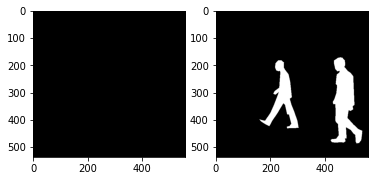

epoch 1, 1/170, loss is 0.12255525588989258


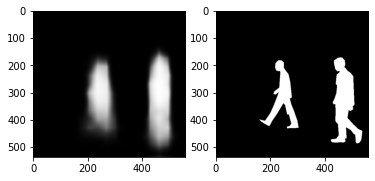

epoch 2, 1/170, loss is 0.09858159720897675


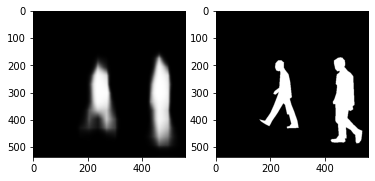

epoch 3, 1/170, loss is 0.08728601038455963


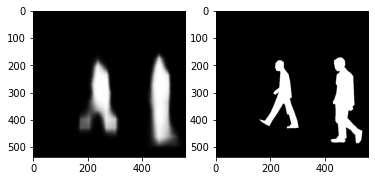

epoch 4, 1/170, loss is 0.07363329827785492


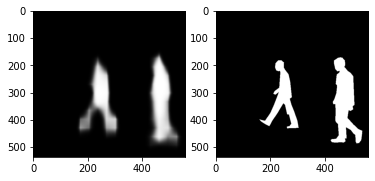

epoch 5, 1/170, loss is 0.07085379213094711


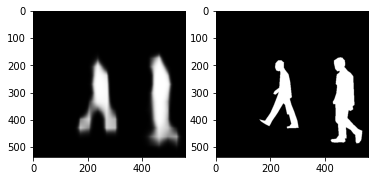

epoch 6, 1/170, loss is 0.06800200045108795


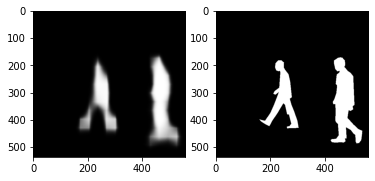

epoch 7, 1/170, loss is 0.07393930107355118


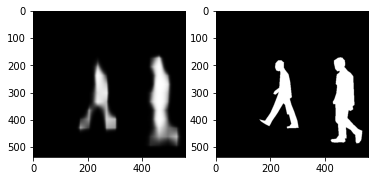

epoch 8, 1/170, loss is 0.08607285469770432


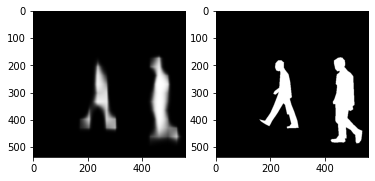

epoch 9, 1/170, loss is 0.07104499638080597


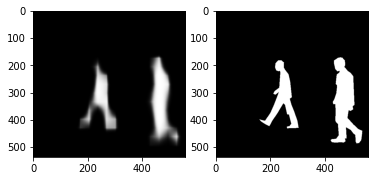

epoch loss = 0.103573


In [7]:
fcn_model = fcn_model32
fcn_model = fcn_model.cuda()
optimizer = optim.SGD(fcn_model.parameters(), lr=1e-2, momentum=0.7) 

for epo in range(10):
  index = 0
  epo_loss = 0
  for img, masks in dataloader:
      index += 1
      input = img
      y = masks
      input = torch.autograd.Variable(input)
      y = torch.autograd.Variable(y)

      input = input.cuda()
      y = y.cuda()

      optimizer.zero_grad()
      output = fcn_model(input)
      output = torch.sigmoid(output)
      loss = criterion(output, y)
      loss.backward()
      iter_loss = loss.data
      epo_loss += iter_loss
      optimizer.step()
      output_np = output.cpu().data.numpy().copy().squeeze(1)
      output_np = output_np * 255
      y_np = y.cpu().data.numpy().copy().squeeze(1)
      y_np = y_np * 255
      output_np = torch.as_tensor(output_np, dtype=torch.uint8)
      y_np = torch.as_tensor(y_np, dtype=torch.uint8)
      image1 = Image.fromarray(output_np[0,:, :].byte().numpy())
      image2 = Image.fromarray(y_np[0, :, :].byte().cpu().numpy())

      img1.append(image1) #######
      img_y1.append(image2) ######

      if np.mod(index, 170) == 1:
        print('epoch {}, {}/{}, loss is {}'.format(epo, index, len(dataloader), iter_loss))
        plt.subplot(1, 2, 1) 
        plt.imshow(image1, 'gray')
        plt.subplot(1, 2, 2) 
        plt.imshow(image2, 'gray')
        plt.show()

print('epoch loss = %f'%(epo_loss/len(dataloader)))    

epoch 0, 1/170, loss is 0.6097231507301331


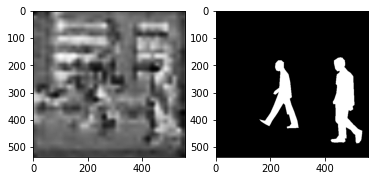

epoch 0, 151/170, loss is 0.12698021531105042


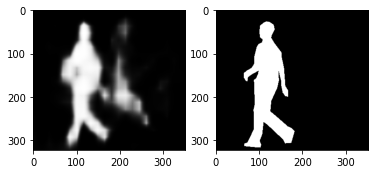

epoch 1, 1/170, loss is 0.044806405901908875


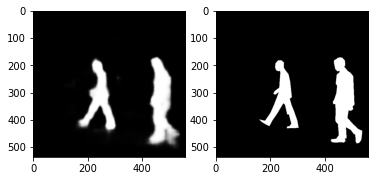

epoch 1, 151/170, loss is 0.090113565325737


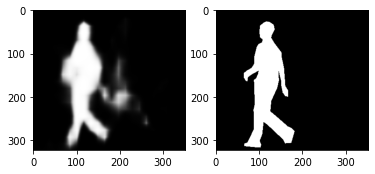

epoch 2, 1/170, loss is 0.03534909710288048


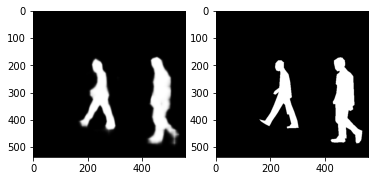

epoch 2, 151/170, loss is 0.07007629424333572


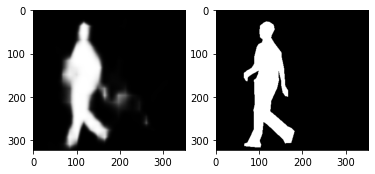

epoch 3, 1/170, loss is 0.03215700387954712


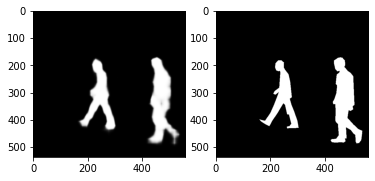

epoch 3, 151/170, loss is 0.06515032052993774


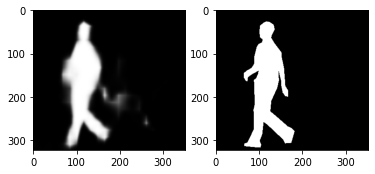

epoch 4, 1/170, loss is 0.02995191141963005


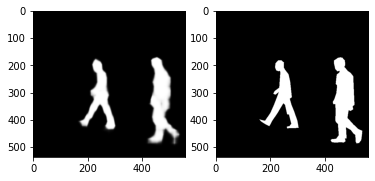

epoch 4, 151/170, loss is 0.057721804827451706


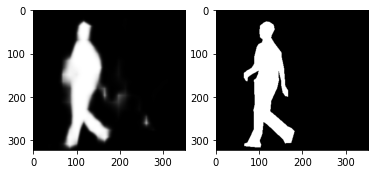

epoch 5, 1/170, loss is 0.03283735737204552


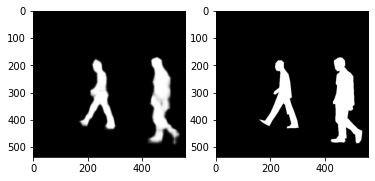

epoch 5, 151/170, loss is 0.05438684672117233


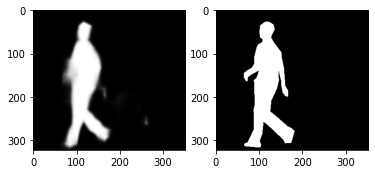

epoch 6, 1/170, loss is 0.03279624134302139


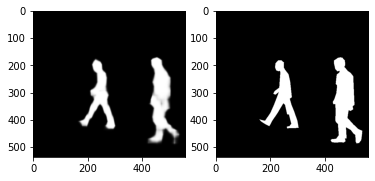

epoch 6, 151/170, loss is 0.052153028547763824


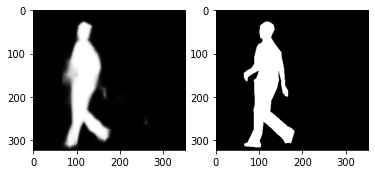

epoch 7, 1/170, loss is 0.033313822001218796


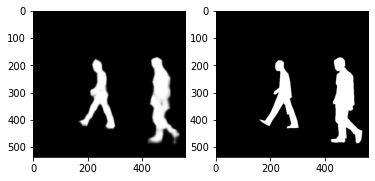

epoch 7, 151/170, loss is 0.048777103424072266


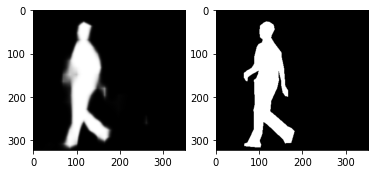

epoch 8, 1/170, loss is 0.0313495434820652


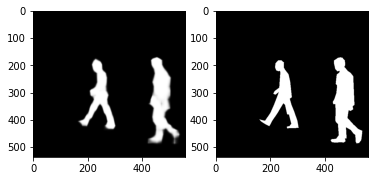

epoch 8, 151/170, loss is 0.04862919822335243


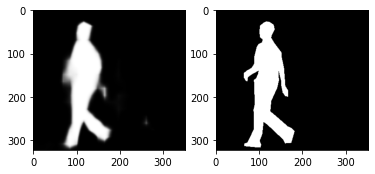

epoch 9, 1/170, loss is 0.029695365577936172


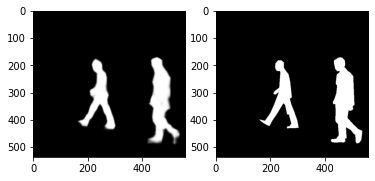

epoch 9, 151/170, loss is 0.04986771568655968


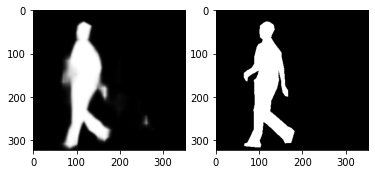

epoch loss = 0.064027


In [8]:
fcn_model = fcn_model16
fcn_model = fcn_model.cuda()
optimizer = optim.SGD(fcn_model.parameters(), lr=1e-2, momentum=0.7) 

for epo in range(10):
  index = 0
  epo_loss = 0
  for img, masks in dataloader:
      index += 1
      input = img
      y = masks
      input = torch.autograd.Variable(input)
      y = torch.autograd.Variable(y)

      input = input.cuda()
      y = y.cuda()

      optimizer.zero_grad()
      output = fcn_model(input)
      output = torch.sigmoid(output)
      loss = criterion(output, y)
      loss.backward()
      iter_loss = loss.data
      epo_loss += iter_loss
      optimizer.step()
      output_np = output.cpu().data.numpy().copy().squeeze(1)
      output_np = output_np * 255
      y_np = y.cpu().data.numpy().copy().squeeze(1)
      y_np = y_np * 255
      output_np = torch.as_tensor(output_np, dtype=torch.uint8)
      y_np = torch.as_tensor(y_np, dtype=torch.uint8)
      image1 = Image.fromarray(output_np[0,:, :].byte().numpy())
      image2 = Image.fromarray(y_np[0, :, :].byte().cpu().numpy())

      img2.append(image1) #######
      img_y2.append(image2) ######

      if np.mod(index, 150) == 1:
        print('epoch {}, {}/{}, loss is {}'.format(epo, index, len(dataloader), iter_loss))
        plt.subplot(1, 2, 1) 
        plt.imshow(image1, 'gray')
        plt.subplot(1, 2, 2) 
        plt.imshow(image2, 'gray')
        plt.show()

print('epoch loss = %f'%(epo_loss/len(dataloader)))  

epoch 0, 1/170, loss is 0.963248074054718


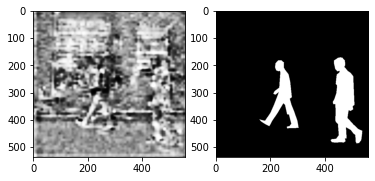

epoch 0, 131/170, loss is 0.0805567055940628


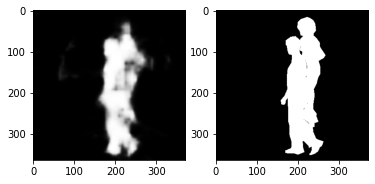

epoch 1, 1/170, loss is 0.05094214156270027


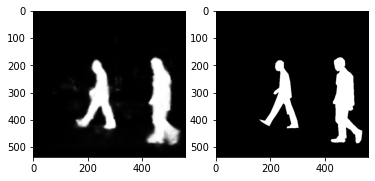

epoch 1, 131/170, loss is 0.052104249596595764


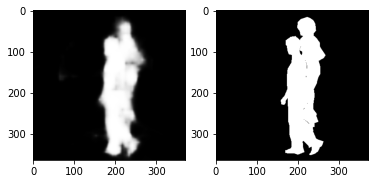

epoch 2, 1/170, loss is 0.03218558058142662


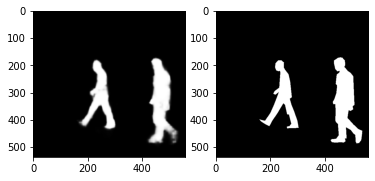

epoch 2, 131/170, loss is 0.045272815972566605


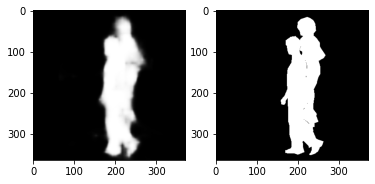

epoch 3, 1/170, loss is 0.028292592614889145


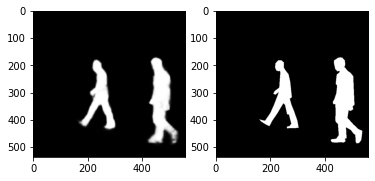

epoch 3, 131/170, loss is 0.04176923260092735


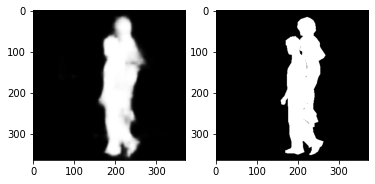

epoch 4, 1/170, loss is 0.02768724597990513


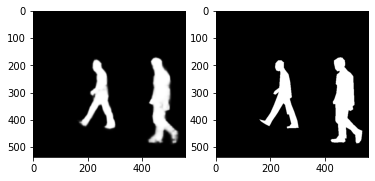

epoch 4, 131/170, loss is 0.04471141844987869


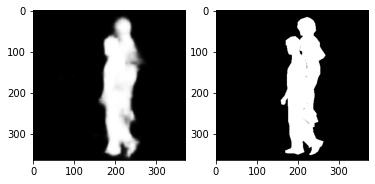

epoch 5, 1/170, loss is 0.027609819546341896


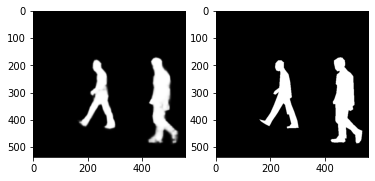

epoch 5, 131/170, loss is 0.040930911898612976


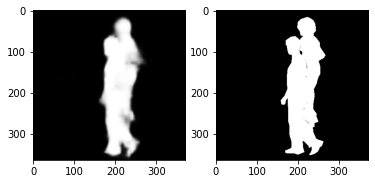

epoch 6, 1/170, loss is 0.029377125203609467


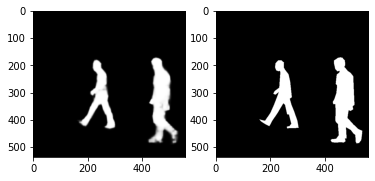

epoch 6, 131/170, loss is 0.042999908328056335


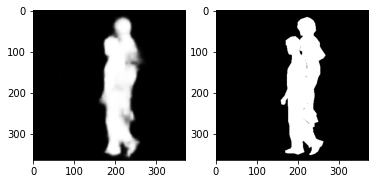

epoch 7, 1/170, loss is 0.03016570210456848


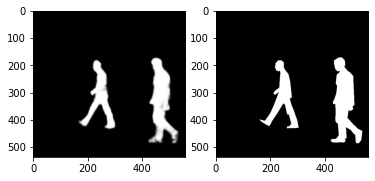

epoch 7, 131/170, loss is 0.04706631228327751


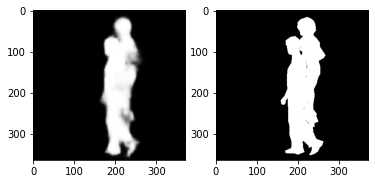

epoch 8, 1/170, loss is 0.025778183713555336


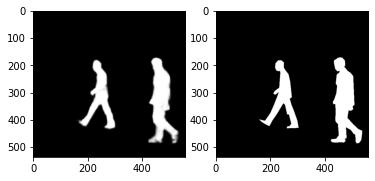

epoch 8, 131/170, loss is 0.04438185691833496


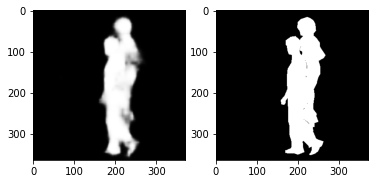

epoch 9, 1/170, loss is 0.02471078746020794


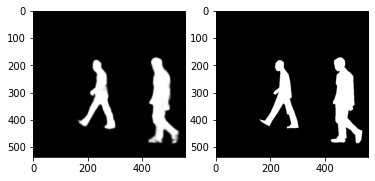

epoch 9, 131/170, loss is 0.0425700880587101


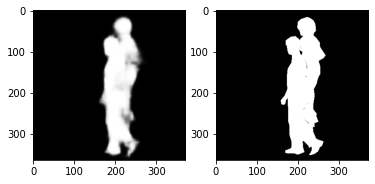

epoch loss = 0.060981


In [9]:
fcn_model = fcn_model8
fcn_model = fcn_model.cuda()
optimizer = optim.SGD(fcn_model.parameters(), lr=1e-2, momentum=0.7) 

for epo in range(10):
  index = 0
  epo_loss = 0
  for img, masks in dataloader:
      index += 1
      input = img
      y = masks
      input = torch.autograd.Variable(input)
      y = torch.autograd.Variable(y)

      input = input.cuda()
      y = y.cuda()

      optimizer.zero_grad()
      output = fcn_model(input)
      output = torch.sigmoid(output)
      loss = criterion(output, y)
      loss.backward()
      iter_loss = loss.data
      epo_loss += iter_loss
      optimizer.step()
      output_np = output.cpu().data.numpy().copy().squeeze(1)
      output_np = output_np * 255
      y_np = y.cpu().data.numpy().copy().squeeze(1)
      y_np = y_np * 255
      output_np = torch.as_tensor(output_np, dtype=torch.uint8)
      y_np = torch.as_tensor(y_np, dtype=torch.uint8)
      image1 = Image.fromarray(output_np[0,:, :].byte().numpy())
      image2 = Image.fromarray(y_np[0, :, :].byte().cpu().numpy())

      img3.append(image1) #######
      img_y3.append(image2) ######

      if np.mod(index, 130) == 1:
        print('epoch {}, {}/{}, loss is {}'.format(epo, index, len(dataloader), iter_loss))
        plt.subplot(1, 2, 1) 
        plt.imshow(image1, 'gray')
        plt.subplot(1, 2, 2) 
        plt.imshow(image2, 'gray')
        plt.show()

print('epoch loss = %f'%(epo_loss/len(dataloader)))  

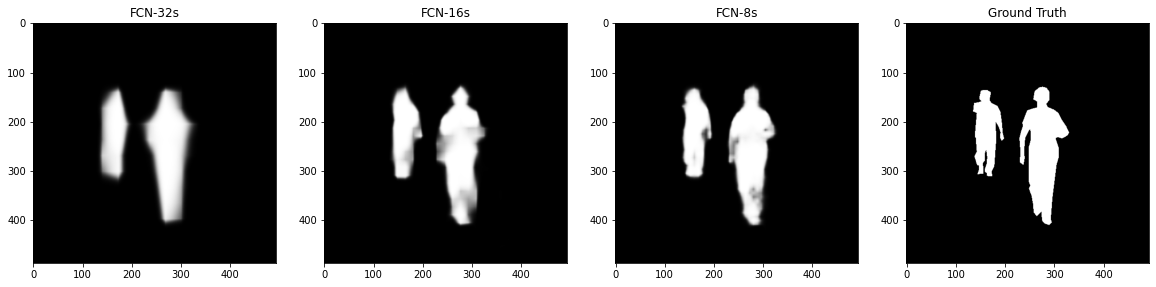

In [89]:
i = 39
idx = 1529 + i

plt.figure(figsize=(20,10))
plt.subplot(1, 4, 1) 
plt.title('FCN-32s')
plt.imshow(img1[idx], 'gray')
plt.subplot(1, 4, 2) 
plt.title('FCN-16s')
plt.imshow(img2[idx], 'gray')
plt.subplot(1, 4, 3)
plt.title('FCN-8s')
plt.imshow(img3[idx], 'gray')
plt.subplot(1, 4, 4)
plt.title('Ground Truth')
plt.imshow(img_y1[idx], 'gray')
plt.show()

In [11]:
import csv

with open('imgs.csv','w',newline='') as f:
  writer = csv.writer(f)
  writer.writerow(img1)
  writer.writerow(img2)
  writer.writerow(img3)
  writer.writerow(img_y1)